In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from shutil import copyfile
from tensorflow import keras

In [2]:
#load one picture and display it
original = cv2.imread('images_sudoku/sudoku0.JPG')
cv2.imshow('original', original)

#make copy for configuration, resize it too, 809 bec of dividing later with 9 
IMAGE_SIZE = (809,809)
original_copy = cv2.resize(original.copy(), IMAGE_SIZE)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
#preprocess image function
def preprocessing_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #eliminates noises in pictures
    blur = cv2.GaussianBlur(gray, (5,5), 1)
    #select areas of an image, while ignoring the parts we are not concerned with
    treshhold = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,3)
    return treshhold

#display image function
def display_image(img):
    cv2.imshow("image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

pre_image = preprocessing_image(original_copy)
display_image(pre_image)

In [4]:
#define contours function
def find_contours(pre_image): 
    #find only external contours
    contours, hierarchy = cv2.findContours(image=pre_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    #draw contours in image
    image_contours = cv2.drawContours(image=original_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    return image_contours

cont_image = find_contours(pre_image)
display_image(cont_image)

In [5]:
#find corners of sudoku square
def find_contours(img):
    #get only "outer" contours with RETR_EXTERNAL
    #ContourArea finds area of outermost polygon(largest feature) in img
    ext_contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ext_contours = ext_contours[0] if len(ext_contours) == 2 else ext_contours[1]
    ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)

    for c in ext_contours:
        peri = cv2.arcLength(c, True)
        #Approximates a polygonal curve(s) with the specified precision
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        if len(approx) == 4:
            #looking for the largest 4 sided contour
            return approx


#define order of corners 
def order_corner_points(corners):
    #Corners[0],... stores in format [[x y]]
    #Separate corners into individual points
    #Index 0 - top-right
    #      1 - top-left
    #      2 - bottom-left
    #      3 - bottom-right
    corners = [(corner[0][0], corner[0][1]) for corner in corners]
    top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
    return top_l, top_r, bottom_r, bottom_l


#delete unnecessary background, so only the sudoku grid is in the picture
def perspective_transform(image, corners): 
    #Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners

    #Determine width of new image which is the max distance between
    #(bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    #Determine height of new image which is the max distance between
    #(top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    #Construct new points to obtain top-down view of image in
    #top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                           [0, height - 1]], dtype="float32")

    #convert to numpy array
    ordered_corners = np.array(ordered_corners, dtype="float32")

    #calculate the perspective transform matrix and warp
    #the perspective to grab the screen
    grid = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    return cv2.warpPerspective(image, grid, (width, height))

#checking corners coordinates
contours = find_contours(pre_image)
ordered_corners = order_corner_points(contours)

#plot red corners
for direction in ordered_corners:
    image_corner = cv2.circle(original_copy, direction, radius=3, color=(0,0,255), thickness=cv2.FILLED)

display_image(image_corner) 


In [6]:
#checking transformed image
trans_image = perspective_transform(original_copy, contours)
display_image(trans_image)

In [7]:
#plot gray scaled
trans_original = perspective_transform(cv2.resize(original, IMAGE_SIZE), contours)
trans_gray = preprocessing_image(trans_original)

#resize it to 809,809 for better division
trans_gray_resized = cv2.resize(trans_gray, IMAGE_SIZE)

display_image(trans_gray_resized)

In [8]:
COLUMNS = ROWS = 9
WIDTH = HEIGHT = 0 

#create 9x9 matrix
matrix = [[0 for x in range(COLUMNS)] for y in range(ROWS)]

#iterate through matrix and split sudoku image in 81 images
for x in range(COLUMNS):   
    WIDTH = 0
    for y in range(ROWS):
        matrix[x][y] = (trans_gray_resized[HEIGHT:(HEIGHT+90)-1,WIDTH:(WIDTH+90)-1])
        WIDTH = WIDTH + 90
        y = y + 1
    x = x + 1
    HEIGHT = HEIGHT + 90
    
#print(matrix)

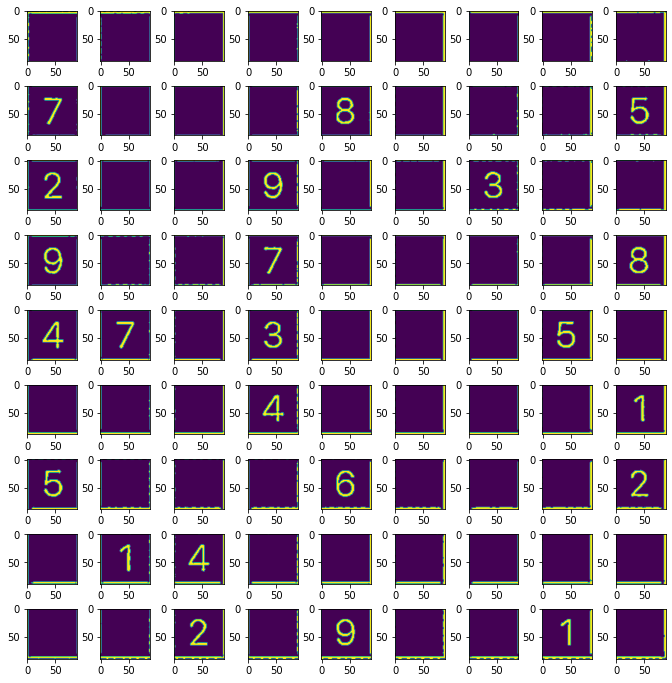

In [9]:
#function to plot 9x9 matrix
def plotmatrix(NULL):
    plt.figure(figsize=(10,10))

    #adjust subplot so you can see all subplots 
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1, 
                        top=1, 
                        wspace=0.25, 
                        hspace=0.5)

    #iterate through all arrays and print them as subplot
    it_sub = 0
    for x in range(COLUMNS):
        for y in range(ROWS):
            plt.subplot(9, 9, it_sub + 1)
            plt.imshow(matrix[x][y])   
            y = y + 1
            it_sub = it_sub + 1
        x = x + 1
    
    plt.show

plotmatrix(0)

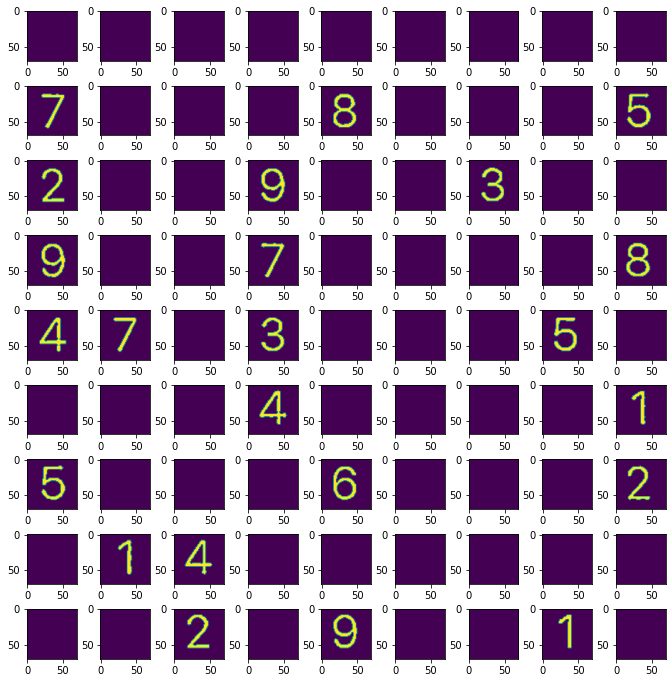

In [10]:
#get ride off the girds in images
def cutgrid(matrix):
    for x in range(COLUMNS):
        for y in range(ROWS):
            image = matrix[x][y]
            image = image[10:80,10:80]
            matrix[x][y] = image

cutgrid(matrix)
plotmatrix(0)

In [11]:
#create train and test directories
if not os.path.isdir('dataset'):
  os.mkdir('dataset')
if not os.path.isdir('dataset/training'):
  os.mkdir('dataset/training')
if not os.path.isdir('dataset/testing'):
  os.mkdir('dataset/testing')

In [12]:
#make class directories inside them
for i in sorted(os.listdir('all_data')):
  if not os.path.isdir('dataset/training/'+i):
    os.mkdir('dataset/training/'+i)
  if not os.path.isdir('dataset/testing/'+i):
    os.mkdir('dataset/testing/'+i)

In [13]:
#copy random images to training or testing folder
base = 'all_data/number_'

for char in range(0, 10):
  classLen = len(os.listdir(base + str(char)))

  trainLen = math.floor(classLen*0.80)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)
  randTrain = randFnt[:trainLen]
  randTest = randFnt[trainLen:]

  for imgNo in randTrain:
    src = base+str(char)+'/img'+str(char+1).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/training/number_'+str(char)+'/img'+str(char+1).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randTest:
    src = base+str(char)+'/img'+str(char+1).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/testing/number_'+str(char)+'/img'+str(char+1).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

In [14]:
#define constants
num_classes = 10
image_resize = 128
num_epochs = 12
batch_size = 64

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense 

from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import Flatten

In [16]:
#create data generator
data_generator = ImageDataGenerator(rescale=1.0/255.0,
                                    validation_split=0.2,
                                    zoom_range=0.2,
                                    width_shift_range=20,
                                    height_shift_range=10,
                                    brightness_range=[0.3,0.9])

In [17]:
#create train and valid generators
train_dir = "dataset/training"

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (image_resize, image_resize),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset= "training"
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (image_resize, image_resize),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset= "validation"
)

Found 4509 images belonging to 10 classes.
Found 1122 images belonging to 10 classes.


In [18]:
#create the model
model = Sequential()
model.add(Conv2D(32, (4,4), strides = (1,1), activation = 'relu', input_shape = (128, 128, 1)))
model.add(MaxPooling2D(pool_size = (4,4), strides = (2,2)))
model.add(Conv2D(64, (4,4), strides = (1,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4,4),strides = (2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])


#view model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211328   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples//batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs,
    verbose = 1
)

Epoch 1/12
70/70 [==============================] - 76s 1s/step - loss: 1.2764 - accuracy: 0.5933 - val_loss: 0.3576 - val_accuracy: 0.9044
Epoch 2/12
70/70 [==============================] - 75s 1s/step - loss: 0.3136 - accuracy: 0.9147 - val_loss: 0.2512 - val_accuracy: 0.9265
Epoch 3/12
70/70 [==============================] - 75s 1s/step - loss: 0.2229 - accuracy: 0.9390 - val_loss: 0.1378 - val_accuracy: 0.9605
Epoch 4/12
70/70 [==============================] - 80s 1s/step - loss: 0.1426 - accuracy: 0.9559 - val_loss: 0.1199 - val_accuracy: 0.9688
Epoch 5/12
70/70 [==============================] - 85s 1s/step - loss: 0.1189 - accuracy: 0.9676 - val_loss: 0.0906 - val_accuracy: 0.9761
Epoch 6/12
70/70 [==============================] - 80s 1s/step - loss: 0.1104 - accuracy: 0.9703 - val_loss: 0.1202 - val_accuracy: 0.9761
Epoch 7/12
70/70 [==============================] - 79s 1s/step - loss: 0.0936 - accuracy: 0.9741 - val_loss: 0.1161 - val_accuracy: 0.9798
Epoch 8/12
70/70 [==

In [28]:
#save the model
model.save("sudoku.h5")

In [ ]:
#load model if you already 
model = tf.keras.models.load_model("sudoku.h5")

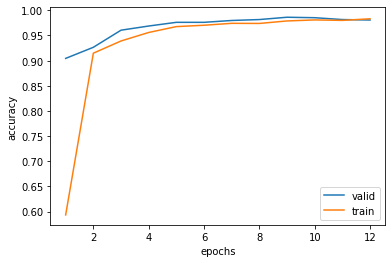

In [21]:
#checking accuracy depending on epochs
plt.plot(range(1,13), history.history['val_accuracy'], label='valid')
plt.plot(range(1,13), history.history['accuracy'], label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
#create test genrator for evalution
test_generator = data_generator.flow_from_directory(
    'dataset/testing',
    target_size = (image_resize, image_resize),
    shuffle = False,
    color_mode='grayscale'
)

Found 1843 images belonging to 10 classes.


In [23]:
#evalute model on test data
eva = model.evaluate(test_generator, verbose=1)
print('Model performance:')
print('loss for test dataset is : {}'.format(eva[0]))
print('accuracy for test dataset is : {}'.format(eva[1]))

58/58 [==============================] - 10s 167ms/step - loss: 0.0655 - accuracy: 0.9832
Model performance:
loss for test dataset is : 0.06549137830734253
accuracy for test dataset is : 0.9831795692443848


In [24]:
# #with this function I looked for a suitable constant for seperating between an empty image and an image with number
# for x in range(COLUMNS):
#         for y in range(ROWS):
#             image = matrix[x][y] 
#             #image = cv2.bitwise_not(image) 
#             print(np.count_nonzero(image), "-------",x , "-------",y)

In [25]:
#function that counts pixel in image to difference between blank image and image with number
def numericallysudoku(matrix):
    for x in range(COLUMNS):
        for y in range(ROWS):
            image = matrix[x][y]      
            #count zeros to differate between image with number and without
            if (np.count_nonzero(image)>300):
                image = cv2.bitwise_not(image)     
                image = cv2.resize(image, (128,128))
                #configurate image format for prediction
                image = image.astype('float32')
                image = image.reshape(1, 128, 128, 1)
                image /= 255
                #prediction 
                pred = model.predict(image)
                matrix[x][y] = pred.argmax()
            else:
                matrix[x][y] = 0
                
numericallysudoku(matrix) 

#print predicted values
print (matrix)

#compare output with image
display_image(trans_gray_resized)

[[0, 0, 0, 0, 0, 0, 0, 0, 0], [7, 0, 0, 0, 8, 0, 0, 0, 5], [2, 0, 0, 9, 0, 0, 3, 0, 0], [9, 0, 0, 7, 0, 0, 0, 0, 8], [4, 7, 0, 3, 0, 0, 0, 5, 0], [0, 0, 0, 4, 0, 0, 0, 0, 1], [5, 0, 0, 0, 6, 0, 0, 0, 2], [0, 1, 4, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 9, 0, 0, 1, 0]]


In [26]:
#code from (https://github.com/techwithtim/Sudoku-GUI-Solver/blob/master/solver%20(text).py)
#code credits to techwithtim

#backtracking algorithm for solving sudoku

def solve(bo):
    """
    Solves a sudoku board using backtracking
    :param bo: 2d list of ints
    :return: solution
    """
    find = find_empty(bo)
    if find:
        row, col = find
    else:
        return True

    for i in range(1,10):
        if valid(bo, (row, col), i):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, pos, num):
    """
    Returns if the attempted move is valid
    :param bo: 2d list of ints
    :param pos: (row, col)
    :param num: int
    :return: bool
    """

    # Check row
    for i in range(0, len(bo)):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check Col
    for i in range(0, len(bo)):
        if bo[i][pos[1]] == num and pos[1] != i:
            return False

    # Check box

    box_x = pos[1]//3
    box_y = pos[0]//3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True


def find_empty(bo):
    """
    finds an empty space in the board
    :param bo: partially complete board
    :return: (int, int) row col
    """

    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)

    return None


def print_board(bo):
    """
    prints the board
    :param bo: 2d List of ints
    :return: None
    """
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - -")
        for j in range(len(bo[0])):
            if j % 3 == 0:
                print(" | ",end="")

            if j == 8:
                print(bo[i][j], end="\n")
            else:
                print(str(bo[i][j]) + " ", end="")

In [27]:
solve(matrix)
print_board(matrix)

 | 1 6 9  | 5 3 7  | 2 8 4
 | 7 4 3  | 6 8 2  | 1 9 5
 | 2 5 8  | 9 4 1  | 3 6 7
- - - - - - - - - - - - - -
 | 9 2 5  | 7 1 6  | 4 3 8
 | 4 7 1  | 3 2 8  | 6 5 9
 | 3 8 6  | 4 5 9  | 7 2 1
- - - - - - - - - - - - - -
 | 5 9 7  | 1 6 3  | 8 4 2
 | 6 1 4  | 8 2 5  | 9 7 3
 | 8 3 2  | 7 9 4  | 5 1 6
